In [1]:
import pandas
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import advertools as adv

In [17]:
posts = ['I am grinning 😀','A grinning cat 😺', 'hello! 😀😀😺 💛💛', 'Just text']
# posts = ['I am grinning 😀']
emoji_summary = adv.extract_emoji(posts)
print(emoji_summary.keys())
print(emoji_summary['emoji'])
print(emoji_summary['emoji_counts'])
print(emoji_summary['top_emoji'])


dict_keys(['emoji', 'emoji_text', 'emoji_flat', 'emoji_flat_text', 'emoji_counts', 'emoji_freq', 'top_emoji', 'top_emoji_text', 'top_emoji_groups', 'top_emoji_sub_groups', 'overview'])
[['😀'], ['😺'], ['😀', '😀', '😺', '💛', '💛'], []]
[1, 1, 5, 0]
[('😀', 3), ('😺', 2), ('💛', 2)]


In [2]:
df1 = pandas.read_csv("data/counterspeech_plf/pre-annotation/plf_replies_100_samples_v3_JB_YC_analysed_final.csv")

In [18]:
# disagreement mostly is duet to lack of context (few words in the replies)
df_reply_mismatch = df1[(df1['is_text_abusive[Y/N]_JB'] == "Y") & (df1['is_text_abusive[Y/N]_YC'] == "Y") & (df1['reply_category_match'] == "N")]
print(df_reply_mismatch.shape)
print(df_reply_mismatch[["w_cnt_reply_group"]].value_counts().sort_index(ascending=True))
# print(df_reply_mismatch[["w_cnt_reply_group", "reply_category_JB"]].value_counts().sort_index(ascending=True))
# print(df_reply_mismatch[["w_cnt_reply_group", "reply_category_YC"]].value_counts().sort_index(ascending=True))

(30, 40)
w_cnt_reply_group
0 <= cnt < 5         16
10 <= cnt < 20        4
20 <= cnt < 30        1
30 <= cnt < 40        2
40 <= cnt             1
5 <= cnt < 10         6
dtype: int64


In [17]:
df_reply_match = df1[(df1['is_text_abusive[Y/N]_JB'] == "Y") & (df1['is_text_abusive[Y/N]_YC'] == "Y") & (df1['reply_category_match'] == "Y")]
print(df_reply_match.shape)
print(df_reply_match[["w_cnt_reply_group"]].value_counts().sort_index(ascending=True))
# print(df_reply_match[["w_cnt_reply_group", "reply_category_JB"]].value_counts().sort_index(ascending=True))

(73, 40)
w_cnt_reply_group
0 <= cnt < 5         27
10 <= cnt < 20       14
20 <= cnt < 30        7
40 <= cnt             3
5 <= cnt < 10        22
dtype: int64


# check the relation between abuse probability and human annotation 
# try to find a cut-off for identifying abusive content

In [20]:
df_uniqe_abu = df1[df1['Rep_cnt'] == "reply_1"]
print(df_uniqe_abu[["ACT_text_abuse_prob_group"]].value_counts().sort_index(ascending=True))#.plot(type="bar")
# print(df_uniqe_abu["ACT_text_abuse_prob"].value_counts(bins=5).sort_index(ascending=True))#.plot(type="bar"))

ACT_text_abuse_prob_group
0.5 <= p < 0.6                9
0.6 <= p < 0.7               15
0.7 <= p < 0.8                9
0.8 <= p < 0.9               17
0.9 <= p                     50
dtype: int64


In [45]:
# annotators think only half of tweets with abuse prob between 0.5 and 0.6 are abusive
# abuse prob between 0.6 and 0.7 seems to be challenging, having more than half of disagreement among annotators, annotators think almost half of tweets are not abusive

# abuse prob above 0.7 can yield most correct prediction (at least 1 annotator think the text is abusive)
# or manual validate the tweets with abuse prob between 0.5 and 0.7
print(df_uniqe_abu[["ACT_text_abuse_prob_group", "is_text_abusive_match"]].value_counts().sort_index(ascending=True))
print(df_uniqe_abu[["ACT_text_abuse_prob_group", "is_text_abusive[Y/N]_JB"]].value_counts().sort_index(ascending=True))
print(df_uniqe_abu[["ACT_text_abuse_prob_group", "is_text_abusive[Y/N]_YC"]].value_counts().sort_index(ascending=True))

ACT_text_abuse_prob_group  is_text_abusive_match
0.5 <= p < 0.6             N                         2
                           Y                         7
0.6 <= p < 0.7             N                         9
                           Y                         6
0.7 <= p < 0.8             N                         1
                           Y                         8
0.8 <= p < 0.9             N                         5
                           Y                        12
0.9 <= p                   N                         6
                           Y                        44
dtype: int64
ACT_text_abuse_prob_group  is_text_abusive[Y/N]_JB
0.5 <= p < 0.6             N                           4
                           Y                           5
0.6 <= p < 0.7             N                          15
0.7 <= p < 0.8             N                           3
                           Y                           6
0.8 <= p < 0.9             N                        

# IRR and plot confusion matrix

In [ ]:
def irr_analysis_multi(df1, column_name):
    r1 = df1[column_name+"_YC"].tolist()
    r2 = df1[column_name+"_JB"].tolist()
    array = [r1, r2]
    k = krippendorff_alpha(array, nominal_metric, missing_items='*')
    print(f'krippendorff for {column_name} is {round(k, 3)}')
    print(f'Cohen’s kappa for {column_name} is {round(cohen_kappa_score(r1, r2), 3)}')

    df_temp = df1[df1[column_name+"_YC"] == df1[column_name+"_JB"]]
    print(df_temp.groupby(column_name+"_YC")[column_name+"_YC"].count())

def clean_text(text):
    try:
        return text.replace("y", "Y").replace("n", "N").strip()
    except:
        return text
    

In [8]:
def plot_confusion_matrix(truth, prediction, agreement, normalise='true'):
    ax= plt.subplot()
    label = ['Agreeing with abuse', 'Attacking abuse', 'Opinions', 'Supporting victims', 'Other']
    matrix = confusion_matrix(truth, prediction, labels=label)
    
    group_counts = [str(value) for value in matrix.flatten()]        
    
    matrix_p = confusion_matrix(truth, prediction, labels=label, normalize=normalise)
    group_percentages = [round(value, 2) for value in matrix_p.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_percentages, group_counts)]
    labels = np.asarray(labels).reshape(5,5)    
    sns.heatmap(matrix_p, annot=labels, xticklabels=label, yticklabels=label, fmt='', linewidths=.5, cmap='YlGnBu')
    
    # labels, title and ticks
    ax.set_xlabel('YC')
    ax.set_ylabel('JB')
    ax.set_title(agreement)

def plot_confusion_matrix_4_classes(truth, prediction, agreement, normalise='true'):
    ax= plt.subplot()
    label = ['Agreeing with abuse', 'Attacking abuse', 'Supporting victims', 'Other']
    matrix = confusion_matrix(truth, prediction, labels=label)
    
    group_counts = [str(value) for value in matrix.flatten()]        
    
    matrix_p = confusion_matrix(truth, prediction, labels=label, normalize=normalise)
    group_percentages = [round(value, 2) for value in matrix_p.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_percentages, group_counts)]
    labels = np.asarray(labels).reshape(4,4)    
    sns.heatmap(matrix_p, annot=labels, xticklabels=label, yticklabels=label, fmt='', linewidths=.5, cmap='YlGnBu')
    
    # labels, title and ticks
    ax.set_xlabel('YC')
    ax.set_ylabel('JB')
    ax.set_title(agreement)

def plot_confusion_matrix_3_classes(truth, prediction, agreement, normalise='true'):
    ax= plt.subplot()
    label = ['Agreeing with abuse', 'Attacking abuse', 'Other']
    matrix = confusion_matrix(truth, prediction, labels=label)
    
    group_counts = [str(value) for value in matrix.flatten()]        
    
    matrix_p = confusion_matrix(truth, prediction, labels=label, normalize=normalise)
    group_percentages = [round(value, 2) for value in matrix_p.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_percentages, group_counts)]
    labels = np.asarray(labels).reshape(3,3)    
    sns.heatmap(matrix_p, annot=labels, xticklabels=label, yticklabels=label, fmt='', linewidths=.5, cmap='YlGnBu')
    
    # labels, title and ticks
    ax.set_xlabel('YC')
    ax.set_ylabel('JB')
    ax.set_title(agreement)

--all entries--

Agreeing with abuse    49
Attacking abuse        38
Other                  30
Opinions               18
Supporting victims      3
Name: reply_category_YC, dtype: int64
Attacking abuse        145
Agreeing with abuse     47
Other                   24
Opinions                 8
Supporting victims       2
Name: reply_category_JB, dtype: int64


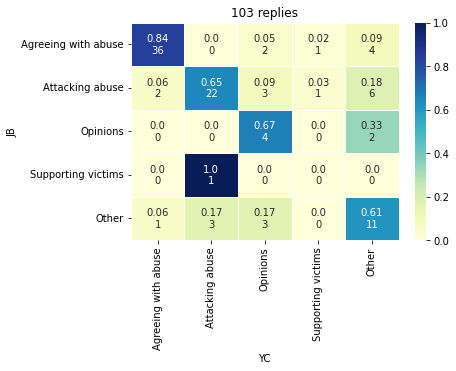

In [9]:
title = '103 replies'
YC, JB = df1['reply_category_YC'].tolist(), df1['reply_category_JB'].tolist()
print('--all entries--\n')
print(df1['reply_category_YC'].value_counts())
print(df1['reply_category_JB'].value_counts())
plot_confusion_matrix(JB, YC, title)

--all entries--

Agreeing with abuse    49
Other                  48
Attacking abuse        38
Supporting victims      3
Name: collapsed_reply_category_YC, dtype: int64
Attacking abuse        145
Agreeing with abuse     47
Other                   32
Supporting victims       2
Name: collapsed_reply_category_JB, dtype: int64


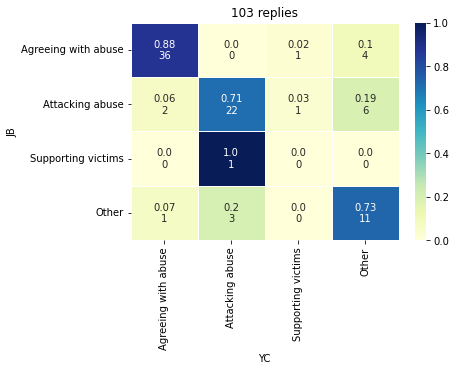

In [10]:
def merge_reply_category(text):
    try:
        return text.replace("Opinions", "Other")
    except:
        return text
df1['collapsed_reply_category_YC'] = df1.apply(lambda x: merge_reply_category(x['reply_category_YC']), axis=1)
df1['collapsed_reply_category_JB'] = df1.apply(lambda x: merge_reply_category(x['reply_category_JB']), axis=1)

title = '103 replies'
YC, JB = df1['reply_category_YC'].tolist(), df1['reply_category_JB'].tolist()
print('--all entries--\n')
print(df1['collapsed_reply_category_YC'].value_counts())
print(df1['collapsed_reply_category_JB'].value_counts())
plot_confusion_matrix_4_classes(JB, YC, title)

--all entries--

Other                  51
Agreeing with abuse    49
Attacking abuse        38
Name: collapsed_reply_category_YC, dtype: int64
Attacking abuse        145
Agreeing with abuse     47
Other                   34
Name: collapsed_reply_category_JB, dtype: int64


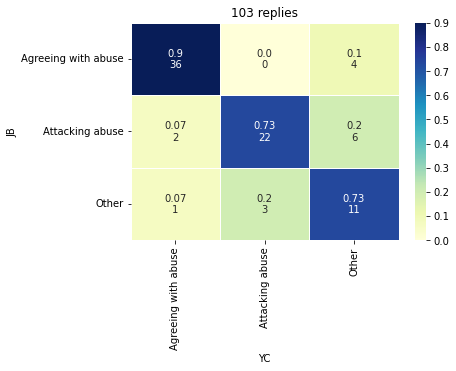

In [11]:
def merge_reply_category(text):
    try:
        return text.replace("Opinions", "Other").replace("Supporting victims", "Other")
    except:
        return text
df1['collapsed_reply_category_YC'] = df1.apply(lambda x: merge_reply_category(x['reply_category_YC']), axis=1)
df1['collapsed_reply_category_JB'] = df1.apply(lambda x: merge_reply_category(x['reply_category_JB']), axis=1)

title = '103 replies'
YC, JB = df1['reply_category_YC'].tolist(), df1['reply_category_JB'].tolist()
print('--all entries--\n')
print(df1['collapsed_reply_category_YC'].value_counts())
print(df1['collapsed_reply_category_JB'].value_counts())
plot_confusion_matrix_3_classes(JB, YC, title)